This kernel used LGBM and treated it as a regression problem. I only did a little feature engineering so far.(just transform some date format features into numeric)

The ideas is that:
- if we treated it as a regression problem, it's better to do some smooth operation. See the [kernel](https://www.kaggle.com/hukuda222/nfl-simple-evluation-trick).
- I used the distribution in [kernel](https://www.kaggle.com/jpmiller/simple-distribution) as my smooth distribution.
- We can see the simple distribution in [kernel](https://www.kaggle.com/jpmiller/simple-distribution) get the 1436 LB. If we use LGBM to do regression prediction and shift the distribution based on the yards we predicte, we should get a better LB. 

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold,TimeSeriesSplit,KFold,GroupKFold
from sklearn.metrics import roc_auc_score,mean_squared_error,mean_absolute_error
from datetime import datetime
import gc
from sklearn.model_selection import TimeSeriesSplit
from bayes_opt import BayesianOptimization
from kaggle.competitions import nflrush
import math
import tqdm
from scipy.spatial.distance import euclidean
from scipy.special import expit
from scipy.spatial import Delaunay, delaunay_plot_2d, Voronoi, voronoi_plot_2d, ConvexHull
import matplotlib.pyplot as plt
pd.set_option("display.max_columns",1000)
env = nflrush.make_env()

In [2]:
train = pd.read_csv('../input/nfl-big-data-bowl-2020/train.csv',low_memory=False)

# preprocess and feature enginnering

In [3]:
train.loc[train.VisitorTeamAbbr == "ARI",'VisitorTeamAbbr'] = "ARZ"
train.loc[train.HomeTeamAbbr == "ARI",'HomeTeamAbbr'] = "ARZ"

train.loc[train.VisitorTeamAbbr == "BAL",'VisitorTeamAbbr'] = "BLT"
train.loc[train.HomeTeamAbbr == "BAL",'HomeTeamAbbr'] = "BLT"

train.loc[train.VisitorTeamAbbr == "CLE",'VisitorTeamAbbr'] = "CLV"
train.loc[train.HomeTeamAbbr == "CLE",'HomeTeamAbbr'] = "CLV"

train.loc[train.VisitorTeamAbbr == "HOU",'VisitorTeamAbbr'] = "HST"
train.loc[train.HomeTeamAbbr == "HOU",'HomeTeamAbbr'] = "HST"

train['is_run'] = train.NflId == train.NflIdRusher

tmp_handoff = train['TimeHandoff'].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
tmp_snap = train['TimeSnap'].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
train['handoff_snap_diff'] = (tmp_handoff - tmp_snap).map(lambda x:x.seconds)

In [4]:
# my original idea for feature engineering---------------------------------------------------
def str_to_float(txt):
    try:
        return float(txt)
    except:
        return -1
    
def yardline_func(row):
    if row["X"] >= 60:
        return 60 + (50 - row["YardLine"])
    else:
        return 10 + row["YardLine"]
    
## standardization ------    
train['ToLeft'] = train.PlayDirection == "left"
train["Dir_std"] = (360 - train.Dir.copy() + 90).mod(360)
train["Orientation_std"] = train["Orientation"].copy()
train.loc[train.Season == 2017, "Orientation_std"] = (360 - train['Orientation_std'][train['Season'] == 2017]).mod(360)
train.loc[train.Season == 2018, "Orientation_std"] = (360 - train['Orientation_std'][train['Season'] == 2018] + 90).mod(360)
# represent Yardline in terms of coordinate X
tmp_df = train.groupby("PlayId").agg("median")[["X", "YardLine"]].reset_index(drop=True)
tmp_yardline = np.array(tmp_df.apply(yardline_func, axis=1))
train["YardLine_std"] = np.repeat(tmp_yardline, 22)
# To unite the offense direction to right, change X, Y, YardLine.
train['X_std'] = train.X.copy()
train.loc[train.ToLeft, 'X_std'] = 120 - train.loc[train.ToLeft, 'X']
train['Y_std'] = train.Y.copy()
train.loc[train.ToLeft, 'Y_std'] = 160/3 - train.loc[train.ToLeft, 'Y']
train.loc[train.ToLeft, "YardLine_std"] = 120 - train["YardLine_std"][train['ToLeft'] == True]
# Additionally, rechange Orientation_std, Dir_std
train.loc[train.ToLeft, "Orientation_std"] = train["Orientation_std"][train['ToLeft'] == True].apply(lambda x: x-180 if x>180 and x<=360 else 180+x)
train.loc[train.ToLeft, "Dir_std"] = train["Dir_std"][train['ToLeft'] == True].apply(lambda x: x-180 if x>180 and x<=360 else 180+x)
# standardization ---------

# age #
FMT_birth = '%m/%d/%Y'
FMT_gamedate = '%Y-%m-%d'
train["Age"] = train["TimeSnap"].apply(lambda t: t.split("T")[0])
train["Age"] = train["Age"].apply(lambda t: datetime.strptime(t, FMT_gamedate))
tmp_birth = train["PlayerBirthDate"].apply(lambda t: datetime.strptime(t, FMT_birth))
train["Age"] = train["Age"] - tmp_birth
train["Age"] = train["Age"].apply(lambda t: t.days//365)

# momentum 
train["Momentum"] = train["S"] * train["PlayerWeight"]

# on offense
def func(row):
    if row["PossessionTeam"] == row["HomeTeamAbbr"]:
        return "home"
    else:
        return "away"
train["OnOffense"] = train[["PossessionTeam", "HomeTeamAbbr"]].apply(func, axis=1)
train["OnOffense"] = train["OnOffense"] == train["Team"]

#train["Margin"] = (train["HomeScoreBeforePlay"] - 
#                train["VisitorScoreBeforePlay"]) + 2 * (1 - (train["PossessionTeam"] == 
#                                                                      train["HomeTeamAbbr"]).astype(int)) * (train["VisitorScoreBeforePlay"] 
#                                                                                                                - train["HomeScoreBeforePlay"])

rusher_x = np.array(train.groupby(["PlayId", "is_run"])["X"].agg(np.mean)[1::2])
rusher_x = np.repeat(rusher_x, 22) # repeat each elemnt 22 times train["RusherX"]
rusher_y = np.array(train.groupby(["PlayId", "is_run"])["Y"].agg(np.mean)[1::2])
rusher_y = np.repeat(rusher_y, 22) # train["RusherY"]
train["DisToRusher"] = np.sqrt((train["X"] - rusher_x) ** 2 + (train["Y"] - rusher_y) ** 2)
train["TackleTimeToRusher"] = train["DisToRusher"] / train["S"] 

rusher_s = np.array(train.groupby(["PlayId", "is_run"]).agg(np.mean)["S"][1::2])
rusher_s = np.repeat(rusher_s, 22)
train["RatioSToRusher"] = train["S"] / rusher_s

# distance without no restriction if the difference between distance is large, the player is restricted by defenders
#train["MoveDist"] = train["S"] * train["handoff_snap_diff"] + 0.5 * train["A"] * (train["handoff_snap_diff"] **2)

# ratio of real movement distance to theoretical movement distance
#train["RealToTheoryDis"] = train["Dis"] / train["MoveDist"]

#train["Ori_Dir_diff"] = train["Dir_std"] - train["Orientation_std"]
# my original idea end ---------------------------------------------------

In [5]:
train_single = train[train.is_run==True].copy()
def transform_time_quarter(str1):
    return int(str1[:2])*60 + int(str1[3:5])
def transform_time_all(str1,quarter):
    if quarter<=4:
        return 15*60 - (int(str1[:2])*60 + int(str1[3:5])) + (quarter-1)*15*60
    if quarter ==5:
        return 10*60 - (int(str1[:2])*60 + int(str1[3:5])) + (quarter-1)*15*60
train_single['time_quarter'] = train_single.GameClock.map(lambda x:transform_time_quarter(x))
train_single['time_end'] = train_single.apply(lambda x:transform_time_all(x.loc['GameClock'],x.loc['Quarter']),axis=1)
# my original idea -----------------------
#def strtoseconds(txt):
#    txt = txt.split(':')
#    ans = int(txt[0])*60 + int(txt[1]) + int(txt[2])/60
#    return ans
#train_single['TimeLeft'] = train_single['GameClock'].apply(strtoseconds)

#train_single['WindSpeed'] = train_single['WindSpeed'].apply(lambda x: x.lower().replace('mph', '').strip() if not pd.isna(x) else x)
#train_single['WindSpeed'] = train_single['WindSpeed'].apply(lambda x: (int(x.split('-')[0])+int(x.split('-')[1]))/2 if not pd.isna(x) and '-' in x else x)
#train_single['WindSpeed'] = train_single['WindSpeed'].apply(lambda x: (int(x.split()[0])+int(x.split()[-1]))/2 if not pd.isna(x) and type(x)!=float and 'gusts up to' in x else x)
#train_single['WindSpeed'] = train_single['WindSpeed'].apply(str_to_float)

#train_single['WindDirection'] = train_single['WindDirection'].apply(lambda x: "north" if x == "N" or x == "FROM S"
#                                                   else ("south" if x == 'S' or x== 'FROM N'
#                                                   else ("west" if x == 'W' or x == 'FROM E'
#                                                   else ("east" if x == 'E' or x == 'FROM W'
#                                                   else ("north east" if x == 'FROM SW' or x == 'FROM SSW' or x == 'FROM WSW'
#                                                   else ("north west" if x == 'FROM SE' or x == 'FROM SSE' or x == 'FROM ESE'
#                                                   else ("south east" if x == 'FROM NW' or x == 'FROM NNW' or x == 'FROM WNW'
#                                                   else ("south west" if x == 'FROM NE' or x == 'FROM NNE' or x == 'FROM ENE'
#                                                   else ("north west" if x == 'NW' or x == 'NORTHWEST'
#                                                   else ("north east" if x == 'NE' or x == 'NORTH EAST'
#                                                   else ("south west" if x == 'SW' or x == 'SOUTHWEST'
#                                                   else ("south east" if x == 'SE' or x == 'SOUTHEAST' else "unknown"))))))))))))

#rain = ['Rainy', 'Rain Chance 40%', 'Showers', 'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
#          'Scattered Showers', 'Cloudy, Rain', 'Rain shower', 'Light Rain', 'Rain']
#overcast = ['Cloudy, light snow accumulating 1-3"', 'Party Cloudy', 'Cloudy, chance of rain','Coudy', 'Cloudy, 50% change of rain', 
#            'Rain likely, temps in low 40s.', 'Cloudy and cold', 'Cloudy, fog started developing in 2nd quarter', 'Partly Clouidy', 
#            '30% Chance of Rain', 'Mostly Coudy', 'Cloudy and Cool', 'cloudy', 'Partly cloudy', 'Overcast', 'Hazy', 'Mostly cloudy', 
#            'Mostly Cloudy', 'Partly Cloudy', 'Cloudy']
#clear = ['Partly clear', 'Sunny and clear', 'Sun & clouds', 'Clear and Sunny', 'Sunny and cold', 'Sunny Skies', 'Clear and Cool', 'Clear and sunny',
#        'Sunny, highs to upper 80s', 'Mostly Sunny Skies', 'Cold', 'Clear and warm', 'Sunny and warm', 'Clear and cold', 'Mostly sunny',
#        'T: 51; H: 55; W: NW 10 mph', 'Clear Skies', 'Clear skies', 'Partly sunny', 'Fair', 'Partly Sunny', 'Mostly Sunny', 'Clear', 'Sunny']
#snow = ['Heavy lake effect snow', 'Snow']
#none = ['N/A Indoor', 'Indoors', 'Indoor', 'N/A (Indoors)', 'Controlled Climate']

#train_single['GameWeather'] = train_single['GameWeather'].apply(lambda x: "rain" if x in rain 
#                                                        else ("overcast" if x in overcast
#                                                        else ("clear" if x in clear
#                                                        else ("snow" if x in snow
#                                                        else ("indoor" if x in none else "unknown")))))

#train_single['GameWeather'] = np.where(train_single.Turf.str.lower().isin(rain), "Rain", "NotRain")

#outdoor =['Outdoor', 'Outdoors', 'Cloudy', 'Heinz Field', 'Outdor', 'Ourdoor', 
#          'Outside', 'Outddors', 'Outdoor Retr Roof-Open', 'Oudoor', 'Bowl']
#indoor_closed = ['Indoors', 'Indoor', 'Indoor, Roof Closed', 'Indoor, Roof Closed', 
#                 'Retractable Roof', 'Retr. Roof-Closed', 'Retr. Roof - Closed', 'Retr. Roof Closed']
#indoor_open = ['Indoor, Open Roof', 'Open', 'Retr. Roof-Open', 'Retr. Roof - Open']
#dome_closed = ['Dome', 'Domed, closed', 'Closed Dome', 'Domed', 'Dome, closed']
#dome_open = ['Domed, Open', 'Domed, open']

#train_single['StadiumType'] = train_single['StadiumType'].apply(lambda x: "outdoor" if x in outdoor 
#                                                    else ("indoor closed" if x in indoor_closed
#                                                    else ("indoor open" if x in indoor_open
#                                                    else ("dome_closed" if x in dome_closed
#                                                    else ("dome_open" if x in dome_open else "unknown")))))

train_single["Location"] = train_single["Location"].map(lambda x: "Arlington, TX" if x == "Arlington, Texas"
                        else ("Baltimore, MD" if x == "Baltimore, Maryland" or x == "Baltimore, Md."
                        else ("Charlotte, NC" if x == "Charlotte, North Carolina"
                        else ("Chicago, IL" if x == "Chicago. IL"
                        else ("Cincinnati, OH" if x == "Cincinnati, Ohio"
                        else ("Cleveland, OH" if x == "Cleveland" or x == "Cleveland Ohio" or x == "Cleveland, Ohio" or x == "Cleveland,Ohio"
                        else ("Detroit, MI" if x == "Detroit"
                        else ("East Rutherford, NJ" if x == "E. Rutherford, NJ" or x == "East Rutherford, N.J."
                        else ("Foxborough, MA" if x == "Foxborough, Ma"
                        else ("Houston, TX" if x == "Houston, Texas"
                        else ("Jacksonville, FL" if x == "Jacksonville Florida" or x == "Jacksonville, Fl" or x == "Jacksonville, Florida"
                        else ("London" if x == "London, England"
                        else ("Los Angeles, CA" if x == "Los Angeles, Calif."
                        else ("Miami Gardens, FLA" if x == "Miami Gardens, Fla."
                        else ("New Orleans, LA" if x == "New Orleans" or x == "New Orleans, La."
                        else ("Orchard Park, NY" if x == "Orchard Park NY"
                        else ("Philadelphia, PA" if x == "Philadelphia, Pa."
                        else ("Pittsburgh, PA" if x == "Pittsburgh"
                        else ("Seattle, WA" if x == "Seattle" else x)))))))))))))))))))

train_single["Stadium"] = train_single["Stadium"].map(lambda x: "Broncos Stadium at Mile High" if x=="Broncos Stadium At Mile High" 
                                             else ("CenturyLink Field" if x == "CenturyField" or x == x=="CenturyLink"
                                             else ("Everbank Field" if x == "EverBank Field"
                                             else ("FirstEnergy Stadium" if x =="First Energy Stadium" or x=="FirstEnergy" or x == "FirstEnergyStadium"
                                             else ("Lambeau Field" if x == "Lambeau field"
                                             else ("Los Angeles Memorial Coliseum" if x == "Los Angeles Memorial Coliesum"
                                             else ("M&T Bank Stadium" if x == "M & T Bank Stadium" or x == "M&T Stadium"
                                             else ("Mercedes-Benz Superdome" if x == "Mercedes-Benz Dome"
                                             else ("MetLife Stadium" if x == "MetLife" or x == "Metlife Stadium"
                                             else ("NRG Stadium" if x == "NRG"
                                             else ("Oakland-Alameda County Coliseum" if x == "Oakland Alameda-County Coliseum"
                                             else ("Paul Brown Stadium" if x == "Paul Brown Stdium"
                                             else ("Twickenham Stadium" if x == "Twickenham" else x)))))))))))))

train_single["OffenseFormation"] = train_single["OffenseFormation"].fillna("Unknown") 
train_single['DefendersInTheBox_vs_Distance'] = train_single['DefendersInTheBox'] / train_single['Distance']

#grass_labels = ['grass', 'natural grass', 'natural', 'naturall grass']
#train_single['Turf'] = np.where(train_single.Turf.str.lower().isin(grass_labels), "Natural", "Artificial")

#arr = [[int(s[0]) for s in t.split(", ")] for t in train_single["DefensePersonnel"]]
#train_single["DefenseDL"] = np.array([a[0] for a in arr])
#train_single["DefenseLB"] = np.array([a[1] for a in arr])
#train_single["DefenseDB"] = np.array([a[2] for a in arr])
#train_single["DefenseOL"] = np.array([a[3] if len(a) == 4 else 0 for a in arr])

#train_single["OffenseRB"] = train_single["OffensePersonnel"].apply(lambda x: 
#                        int(x.replace(",", "").split(" RB")[0][-1]) if "RB" in x else 0)
#train_single["OffenseTE"] = train_single["OffensePersonnel"].apply(lambda x: 
#                        int(x.replace(",", "").split(" TE")[0][-1]) if "TE" in x else 0)
#train_single["OffenseWR"] = train_single["OffensePersonnel"].apply(lambda x: 
#                        int(x.replace(",", "").split(" WR")[0][-1]) if "WR" in x else 0)
#train_single["OffenseOL"] = train_single["OffensePersonnel"].apply(lambda x: 
#                        int(x.replace(",", "").split(" OL")[0][-1]) if "OL" in x else 0)
#train_single["OffenseDL"] = train_single["OffensePersonnel"].apply(lambda x: 
#                        int(x.replace(",", "").split(" DL")[0][-1]) if "DL" in x else 0)
#train_single["OffenseQB"] = train_single["OffensePersonnel"].apply(lambda x: 
#                        int(x.replace(",", "").split(" QB")[0][-1]) if "QB" in x else 0)

# train_single["DownQuarter"] = train_single[["Down", "Quarter"]].apply(lambda x: "D{}_Q{}".format(x[0], x[1]), axis=1)

# necessary yard per remaining down 
train_single["NecDisPerDown"] = train_single["Distance"] / (5 - train_single["Down"])
# my original idea end -----------------------

In [6]:
remove_features = ['GameId','PlayId','DisplayName','GameClock','TimeHandoff','TimeSnap', 
                   "PlayDirection", "YardLine", "Orientation", "Dir", "X", "Y", "ToLeft"]
train_single['date_game'] = train_single.GameId.map(lambda x:pd.to_datetime(str(x)[:8]))
remove_features.append('HomeTeamAbbr')
remove_features.append('VisitorTeamAbbr')
remove_features.append('PlayerBirthDate')
remove_features.append('is_run')
def transform_height(te):
    return (int(te.split('-')[0])*12 + int(te.split('-')[1]))*2.54/100
train_single['runner_height'] = train_single.PlayerHeight.map(transform_height)
remove_features.append('PossessionTeam')
remove_features.append('FieldPosition')
remove_features.append('PlayerHeight')
remove_features.append('NflIdRusher')
remove_features.append('date_game')
train_single['own_field'] = (train_single['FieldPosition'] == train_single['PossessionTeam']).astype(int)
dist_to_end_train = train_single.apply(lambda x:(100 - x.loc['YardLine']) if x.loc['own_field']==1 else x.loc['YardLine'],axis=1)
remove_features.append('own_field')
train_single.drop(remove_features,axis=1,inplace=True)
train_single.fillna(-999,inplace=True)

In [7]:
y_train = train_single.Yards
X_train = train_single.drop(['Yards'],axis=1)
for f in X_train.columns:
    if X_train[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f])+[-999])
        X_train[f] = lbl.transform(list(X_train[f]))

In [8]:
# additional feature engineering -----------------------------------------------------------
def voronoi_volumes(points, selected_index):
    v = Voronoi(points)
    vol = np.zeros(v.npoints)
    
    for i, reg_num in enumerate(v.point_region):
        indices = v.regions[reg_num]
        if -1 in indices: # some regions can be opened
            vol[i] = -999 ## insert missing value when the area is open
        else:
            vol[i] = ConvexHull(v.vertices[indices]).volume
        
        if reg_num == v.point_region[selected_index]: # in the case of rusher or 1st defender etc...
            index = i
            rusher_reg_num = reg_num         
        
    return vol[index]

X_train.rename(columns={'X_std': 'X', "Y_std": "Y", "Dir_std": "Dir", "YardLine_std": "YardLine", 
                        "Orientation_std": "Orientation"}, inplace=True)

tmp = train.groupby(["PlayId", "OnOffense"]).agg(np.mean)[["S", "X", "Y", "Age"]]
X_train["DefenseAveSpeed"] = np.array(tmp[0::2]["S"])
X_train["OffenseAveSpeed"] = np.array(tmp[1::2]["S"])

X_train["DefenseAveX"] = np.array(tmp[0::2]["X"])
X_train["OffenseAveX"] = np.array(tmp[1::2]["X"])

X_train["DefenseAveY"] = np.array(tmp[0::2]["Y"]) 
X_train["OffenseAveY"] = np.array(tmp[1::2]["Y"]) 

X_train["DefenseAveAge"] = np.array(tmp[0::2]["Age"])
X_train["OffenseAveAge"] = np.array(tmp[1::2]["Age"])

tmp = train.groupby(["PlayId", "OnOffense"]).agg(["std"])[["X", "Y"]]
X_train["DefenseStdX"] = np.array(tmp[0::2]["X"])
X_train["OffenseStdX"] = np.array(tmp[1::2]["X"])

X_train["DefenseStdY"] = np.array(tmp[0::2]["Y"])
X_train["OffenseStdY"] = np.array(tmp[1::2]["Y"])

X_train["RunnerToDefenseCentoid"] = np.sqrt((X_train["X"] - X_train["DefenseAveX"]) ** 2 + (X_train["Y"] - X_train["DefenseAveY"]) ** 2)
X_train["RunnerToOffenseCentoid"] = np.sqrt((X_train["X"] - X_train["OffenseAveX"]) ** 2 + (X_train["Y"] - X_train["OffenseAveY"]) ** 2)

# defense x spread, offense x spread
tmp_max = train.groupby(["PlayId", "OnOffense"])["X"].max()
tmp_min = train.groupby(["PlayId", "OnOffense"])["X"].min()
X_train["DefenseSpreadX"] = np.array(tmp_max[0::2]- tmp_min[0::2])
X_train["OffenseSpreadX"] = np.array(tmp_max[1::2]- tmp_min[1::2])

X_train["RunnerToScrimmage"] = X_train["X"] - X_train["YardLine"]

# runner horizontal and vertical speed
#radian_angle = (90 - X_train['Dir']) * np.pi / 180.0
radian_angle = X_train['Dir'] * np.pi / 180.0
X_train['v_horizontal'] = np.abs(X_train['S'] * np.cos(radian_angle))
X_train['v_vertical'] = np.abs(X_train['S'] * np.sin(radian_angle))

# runner horizontal and vertical momentum
X_train['m_horizontal'] = np.abs(X_train['Momentum'] * np.cos(radian_angle))
X_train['m_vertical'] = np.abs(X_train['Momentum'] * np.sin(radian_angle))

# minimum distance to rusher from defenders
X_train["MinDisFromRushToDef"] = np.array(train.groupby(["PlayId", "OnOffense"])["DisToRusher"].min()[0::2])

# tackle time from closest defender to rusher
X_train["MinTackleTime"] = np.array(train.groupby(["PlayId", "OnOffense"])["TackleTimeToRusher"].min()[0::2])

# average tackle time from all defenders to rusher
X_train["AveTackleTime"] = np.array(train.groupby(["PlayId", "OnOffense"]).agg(np.mean)["TackleTimeToRusher"][0::2])

# runner vs 1st defender speed: runner's velocity divided by closest defender's speed
X_train["RatioSRusherToCloseDef"] = np.array(train.loc[train.groupby(["PlayId", "OnOffense"])["DisToRusher"].idxmin()[0::2]]["RatioSToRusher"])

# runner horizontal and vertical distance
X_train["dis_horizontal"] = np.abs(X_train['Dis'] * np.cos(radian_angle))
X_train["dis_vertical"] = np.abs(X_train['Dis'] * np.sin(radian_angle))
X_train["RunnerMoveRatio"] = X_train["dis_horizontal"] / X_train["dis_vertical"]

# the momentum of 1st closest defender to rusher, horizontal momentum, vertical momentum
X_train["DefMomentumCloToRusher"] = np.array(train.loc[train.groupby(["PlayId", "OnOffense"])["DisToRusher"].idxmin()[0::2]]["Momentum"])
X_train["DefMomentumCloToRusher_horizontal"] = np.abs(X_train['DefMomentumCloToRusher'] * np.cos(radian_angle))
X_train["DefMomentumCloToRusher_vertical"] = np.abs(X_train['DefMomentumCloToRusher'] * np.sin(radian_angle))

# the horizontal, vertical mometum of rusher
X_train["RusherMomentum_horizontal"] =  np.abs(X_train['Momentum'] * np.cos(radian_angle))
X_train["RusherMomentum_vertical"] =  np.abs(X_train['Momentum'] * np.sin(radian_angle))

# difference of horizontal momentum 
X_train["hMomentum_rusher_vs_defender"] = X_train["RusherMomentum_horizontal"] - X_train["DefMomentumCloToRusher_horizontal"]

# voronoi area
#pts = np.array(train[["X", "Y"]]).reshape(train.shape[0]//22, 22, 2) # plays * players * (X, Y, rusher)
# index of row where rusher data is included when separated by each play
#rusher_index = list(train[train.is_run==True].index % 22) 
#closest_def_index = list(train.loc[train.groupby(["PlayId", "OnOffense"])["DisToRusher"].idxmin()[0::2]].index % 22)
#rusher_voronoi = []
#closest_def_voronoi = []
#for i in range(0, train.shape[0] //22):
    ##rusher_voronoi.append(voronoi_volumes(pts[i], rusher_index[i]))
    #closest_def_voronoi.append(voronoi_volumes(pts[i], closest_def_index[i]))
##X_train["RusherVoronoi"] = rusher_voronoi    
#X_train["FirstDefenderVoronoi"] = closest_def_voronoi 

#tmp_df = train[["PlayId", "OnOffense", "DisToRusher"]].copy()
#tmp_df["3yards"] = train["DisToRusher"].apply(lambda x: 1 if x<=3 else 0)
#tmp_df["5yards"] = train["DisToRusher"].apply(lambda x: 1 if x<=5 else 0)
#tmp_df["7yards"] = train["DisToRusher"].apply(lambda x: 1 if x<=7 else 0)
#tmp_df["10yards"] = train["DisToRusher"].apply(lambda x: 1 if x<=10 else 0)
#tmp_yard_defense = tmp_df.groupby(["PlayId", "OnOffense"]).agg(np.sum)[["3yards", "5yards", "7yards", "10yards"]][0::2]
#tmp_yard_offense = tmp_df.groupby(["PlayId", "OnOffense"]).agg(np.sum)[["3yards", "5yards", "7yards", "10yards"]][1::2]
#X_train["Offense3yards"] = np.array(tmp_yard_offense["3yards"]-1)
#X_train["Offense5yards"] = np.array(tmp_yard_offense["5yards"]-1)
#X_train["Offense7yards"] = np.array(tmp_yard_offense["7yards"]-1)
#X_train["Offense10yards"] = np.array(tmp_yard_offense["10yards"]-1)
#X_train["Defense3yards"] = np.array(tmp_yard_defense["3yards"])
#X_train["Defense5yards"] = np.array(tmp_yard_defense["5yards"])
#X_train["Defense7yards"] = np.array(tmp_yard_defense["7yards"])
#X_train["Defense10yards"] = np.array(tmp_yard_defense["10yards"])

#X_train = X_train.drop(['RatioSToRusher', 'TackleTimeToRusher', 'OnOffense', 'RusherMomentum_horizontal', 'RusherMomentum_vertical', 'DisToRusher'],axis=1)
# additional feature engineering end ---------------------------------------------------------

In [9]:
def radius_calc(dist_to_ball):
    ''' I know this function is a bit awkward but there is not the exact formula in the paper,
    so I try to find something polynomial resembling
    Please consider this function as a parameter rather than fixed
    I'm sure experts in NFL could find a way better curve for this'''
    return 4 + 6 * (dist_to_ball >= 15) + (dist_to_ball ** 3) / 560 * (dist_to_ball < 15)

@np.vectorize
def compute_influence(x_point, y_point, player_id):
    '''Compute the influence of a certain player over a coordinate (x, y) of the pitch
    '''
    point = np.array([x_point, y_point])
    theta = math.radians(my_play.loc[player_id]['Orientation'])
    speed = my_play.loc[player_id]['S']
    player_coords = my_play.loc[player_id][['X', 'Y']].values
    ball_coords = my_play[my_play['is_run']][['X', 'Y']].values
    
    dist_to_ball = euclidean(player_coords, ball_coords)

    S_ratio = (speed / 13) ** 2    # we set max_speed to 13 m/s
    RADIUS = radius_calc(dist_to_ball)  # updated

    S_matrix = np.matrix([[RADIUS * (1 + S_ratio), 0], [0, RADIUS * (1 - S_ratio)]])
    R_matrix = np.matrix([[np.cos(theta), - np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    COV_matrix = np.dot(np.dot(np.dot(R_matrix, S_matrix), S_matrix), np.linalg.inv(R_matrix))
    
    norm_fact = (1 / 2 * np.pi) * (1 / np.sqrt(np.linalg.det(COV_matrix)))    
    mu_play = player_coords + speed * np.array([np.cos(theta), np.sin(theta)]) / 2
    
    intermed_scalar_player = np.dot(np.dot((player_coords - mu_play),
                                    np.linalg.inv(COV_matrix)),
                             np.transpose((player_coords - mu_play)))
    player_influence = norm_fact * np.exp(- 0.5 * intermed_scalar_player[0, 0])
    
    intermed_scalar_point = np.dot(np.dot((point - mu_play), 
                                    np.linalg.inv(COV_matrix)), 
                             np.transpose((point - mu_play)))
    point_influence = norm_fact * np.exp(- 0.5 * intermed_scalar_point[0, 0])

    return point_influence / player_influence

@np.vectorize
def pitch_control(x_point, y_point):
    '''Compute the pitch control over a coordinate (x, y)
    '''    
    home_ids = my_play[my_play['Team']=='home'].index
    home_control = np.around(compute_influence(x_point, y_point, home_ids), 2)
    home_score = np.sum(home_control)
    
    away_ids = my_play[my_play['Team']=='away'].index
    away_control = np.around(compute_influence(x_point, y_point, away_ids), 2)
    away_score = np.sum(away_control)
    
    return expit(home_score - away_score)

Player coordinates:  [31.19 25.68]


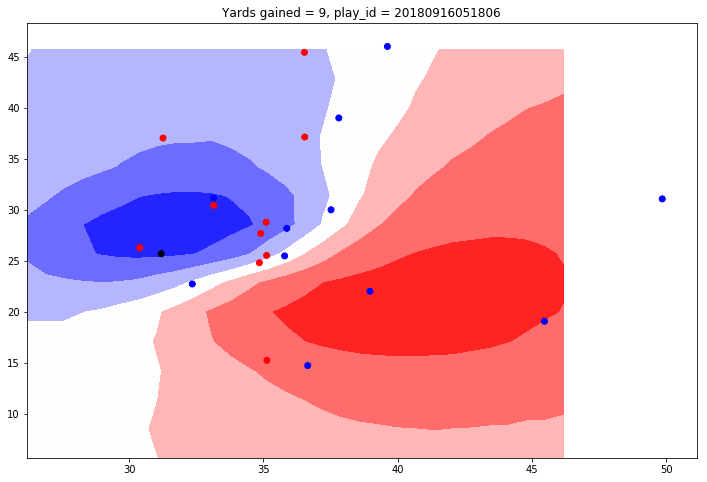

In [10]:
my_play_id = 20180916051806
my_play = train[train['PlayId']==my_play_id]
player_coords = my_play[my_play['is_run']][['X', 'Y']].values[0]
print('Player coordinates: ', player_coords)

front = 15
behind = 5
left = right = 20
num_points_meshgr = (30, 15)   # don't make it too large otherwise it'll be long to run


colorm = ['red'] * 11 + ['blue'] * 11
colorm[np.where(my_play.is_run.values)[0][0]] = 'black'

X, Y = np.meshgrid(np.linspace(player_coords[0] - behind, 
                               player_coords[0] + front, 
                               num_points_meshgr[0]), 
                   np.linspace(player_coords[1] - left, 
                               player_coords[1] + right, 
                               num_points_meshgr[1]))

# infl is an array of shape num_points with values in [0,1] accounting for the pitch control
infl = pitch_control(X, Y)

plt.figure(figsize=(12, 8))
plt.contourf(X, Y, infl, cmap ='bwr')
plt.scatter(my_play['X'].values, my_play['Y'].values, c=colorm)
plt.title('Yards gained = {}, play_id = {}'.format(my_play['Yards'].values[0], my_play_id))
plt.show()

# Model Training

In [11]:
def get_cdf_df(yards_array):
    pdf, edges = np.histogram(yards_array, bins=199,
                 range=(-99,100), density=True)
    cdf = pdf.cumsum().clip(0, 1)
    cdf_df = pd.DataFrame(data=cdf.reshape(-1, 1).T, 
                            columns=['Yards'+str(i) for i in range(-99,100)])
    return cdf_df
cdf = get_cdf_df(y_train).values.reshape(-1,)

def get_score(y_pred,cdf,w,dist_to_end):
    y_pred = int(y_pred)
    if y_pred ==w:
        y_pred_array = cdf.copy()
    elif y_pred - w >0:
        y_pred_array = np.zeros(199)
        y_pred_array[(y_pred-w):] = cdf[:(-(y_pred-w))].copy()
    elif w - y_pred >0:
        y_pred_array = np.ones(199)
        y_pred_array[:(y_pred-w)] = cdf[(w-y_pred):].copy()
    y_pred_array[-1]=1
    y_pred_array[(dist_to_end+99):]=1
    return y_pred_array    

def get_score_pingyi1(y_pred,y_true,cdf,w,dist_to_end):
    y_pred = int(y_pred)
    if y_pred ==w:
        y_pred_array = cdf.copy()
    elif y_pred - w >0:
        y_pred_array = np.zeros(199)
        y_pred_array[(y_pred-w):] = cdf[:(-(y_pred-w))].copy()
    elif w - y_pred >0:
        y_pred_array = np.ones(199)
        y_pred_array[:(y_pred-w)] = cdf[(w-y_pred):].copy()
    y_pred_array[-1]=1
    y_pred_array[(dist_to_end+99):]=1
    y_true_array = np.zeros(199)
    y_true_array[(y_true+99):]=1
    return np.mean((y_pred_array - y_true_array)**2)

def CRPS_pingyi1(y_preds,y_trues,w,cdf,dist_to_ends):
    if len(y_preds) != len(y_trues):
        print('length does not match')
        return None
    n = len(y_preds)
    tmp = []
    for a,b,c in zip(y_preds, y_trues,dist_to_ends):
        tmp.append(get_score_pingyi1(a,b,cdf,w,c))
    return np.mean(tmp)

# evaluation metric
def crps(y_true, y_pred):
    y_true = np.clip(np.cumsum(y_true, axis=1), 0, 1)
    y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
    return ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * y_true.shape[0]) 

In [12]:
n_folds=5
kf=KFold(n_splits = n_folds, shuffle=True, random_state=42)
resu1 = 0
impor1 = 0
resu2_cprs = 0
resu3_mae=0
##y_pred = 0
feature_importance_df = pd.DataFrame(X_train.columns, columns=["feature"])
stack_train = np.zeros([X_train.shape[0],])
models = []
for fold_, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
    X_train2= X_train.iloc[train_index,:]
    y_train2= y_train.iloc[train_index]
    X_test2= X_train.iloc[test_index,:]
    y_test2= y_train.iloc[test_index]
    clf = lgb.LGBMRegressor(n_estimators=10000, random_state=47,learning_rate=0.005,importance_type = 'gain',
                     n_jobs = -1,metric='mae')
    clf.fit(X_train2,y_train2,eval_set = [(X_train2,y_train2),(X_test2,y_test2)],early_stopping_rounds=200,verbose=50)
    feature_importance_df["Fold"+str(fold_)] = clf.feature_importances_
    models.append(clf)
    temp_predict = clf.predict(X_test2)
    stack_train[test_index] = temp_predict
    ##y_pred += clf.predict(X_test)/n_folds
    mse = mean_squared_error(y_test2, temp_predict)
    crps = CRPS_pingyi1(temp_predict,y_test2,4,cdf,dist_to_end_train.iloc[test_index])
    mae = mean_absolute_error(y_test2, temp_predict)
    print(crps)
    
    resu1 += mse/n_folds
    resu2_cprs += crps/n_folds
    resu3_mae += mae/n_folds
    impor1 += clf.feature_importances_/n_folds
    gc.collect()
print('mean mse:',resu1)
print('oof mse:',mean_squared_error(y_train,stack_train))
print('mean mae:',resu3_mae)
print('oof mae:',mean_absolute_error(y_train,stack_train))
print('mean cprs:',resu2_cprs)
print('oof cprs:',CRPS_pingyi1(stack_train,y_train,4,cdf,dist_to_end_train))

feature_importance_df["Average"] = np.mean(feature_importance_df.iloc[:,1:], axis=1)
#feature_importance_df["Std"] = np.std(feature_importance_df.iloc[:,1:5], axis=1)
feature_importance_df = feature_importance_df.sort_values("Average", ascending=False).reset_index(drop=True)

Training until validation scores don't improve for 200 rounds.
[50]	training's l1: 3.75151	valid_1's l1: 3.76589
[100]	training's l1: 3.66926	valid_1's l1: 3.69598
[150]	training's l1: 3.60646	valid_1's l1: 3.64446
[200]	training's l1: 3.55882	valid_1's l1: 3.61362
[250]	training's l1: 3.52178	valid_1's l1: 3.59257
[300]	training's l1: 3.48857	valid_1's l1: 3.57715
[350]	training's l1: 3.46067	valid_1's l1: 3.56744
[400]	training's l1: 3.43427	valid_1's l1: 3.55951
[450]	training's l1: 3.41114	valid_1's l1: 3.5538
[500]	training's l1: 3.38981	valid_1's l1: 3.54911
[550]	training's l1: 3.36903	valid_1's l1: 3.54455
[600]	training's l1: 3.34942	valid_1's l1: 3.54167
[650]	training's l1: 3.33105	valid_1's l1: 3.53875
[700]	training's l1: 3.31314	valid_1's l1: 3.537
[750]	training's l1: 3.29562	valid_1's l1: 3.53559
[800]	training's l1: 3.27908	valid_1's l1: 3.53348
[850]	training's l1: 3.26361	valid_1's l1: 3.53382
[900]	training's l1: 3.2487	valid_1's l1: 3.53466
[950]	training's l1: 3.2

- mean mse: 37.506906623190936
- oof mse: 37.50709773495258
- mean mae: 3.544533086069717
- oof mae: 3.5445321933905447
- mean cprs: 0.013242423035214999
- oof cprs: 0.013242424127343047

# prediction

In [13]:
def transform_test(test):
    test.loc[test.VisitorTeamAbbr == "ARI",'VisitorTeamAbbr'] = "ARZ"
    test.loc[test.HomeTeamAbbr == "ARI",'HomeTeamAbbr'] = "ARZ"

    test.loc[test.VisitorTeamAbbr == "BAL",'VisitorTeamAbbr'] = "BLT"
    test.loc[test.HomeTeamAbbr == "BAL",'HomeTeamAbbr'] = "BLT"

    test.loc[test.VisitorTeamAbbr == "CLE",'VisitorTeamAbbr'] = "CLV"
    test.loc[test.HomeTeamAbbr == "CLE",'HomeTeamAbbr'] = "CLV"

    test.loc[test.VisitorTeamAbbr == "HOU",'VisitorTeamAbbr'] = "HST"
    test.loc[test.HomeTeamAbbr == "HOU",'HomeTeamAbbr'] = "HST"
    
    test['is_run'] = test.NflId == test.NflIdRusher
    
    tmp_handoff = test['TimeHandoff'].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
    tmp_snap = test['TimeSnap'].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
    test['handoff_snap_diff'] = (tmp_handoff - tmp_snap).map(lambda x:x.seconds)
    
    # my original idea for feature engineering -------------------------------------------------------------
    
    ## standardization ------    
    test['ToLeft'] = test.PlayDirection == "left"
    test["Dir_std"] = (360 - test.Dir.copy() + 90).mod(360)
    test["Orientation_std"] = test["Orientation"].copy()
    test.loc[test.Season == 2017, "Orientation_std"] = (360 - test['Orientation_std'][train['Season'] == 2017]).mod(360)
    test.loc[test.Season == 2018, "Orientation_std"] = (360 - test['Orientation_std'][train['Season'] == 2018] + 90).mod(360)
    # represent Yardline in terms of coordinate X
    tmp_df = test.groupby("PlayId").agg("median")[["X", "YardLine"]].reset_index(drop=True)
    tmp_yardline = np.array(tmp_df.apply(yardline_func, axis=1))
    test["YardLine_std"] = np.repeat(tmp_yardline, 22)
    # To unite the offense direction to right, change X, Y, YardLine.
    test['X_std'] = test.X.copy()
    test.loc[test.ToLeft, 'X_std'] = 120 - test.loc[test.ToLeft, 'X']
    test['Y_std'] = test.Y.copy()
    test.loc[test.ToLeft, 'Y_std'] = 160/3 - test.loc[test.ToLeft, 'Y']
    test.loc[test.ToLeft, "YardLine_std"] = 120 - test["YardLine_std"][test['ToLeft'] == True]
    # Additionally, rechange Orientation_std, Dir_std
    test.loc[test.ToLeft, "Orientation_std"] = test["Orientation_std"][test['ToLeft'] == True].apply(lambda x: x-180 if x>180 and x<=360 else 180+x)
    test.loc[test.ToLeft, "Dir_std"] = test["Dir_std"][test['ToLeft'] == True].apply(lambda x: x-180 if x>180 and x<=360 else 180+x)
    # standardization ---------
    
    FMT_birth = '%m/%d/%Y'
    FMT_gamedate = '%Y-%m-%d'
    test["Age"] = test["TimeSnap"].apply(lambda t: t.split("T")[0])
    test["Age"] = test["Age"].apply(lambda t: datetime.strptime(t, FMT_gamedate))
    tmp_birth = test["PlayerBirthDate"].apply(lambda t: datetime.strptime(t, FMT_birth))
    test["Age"] = test["Age"] - tmp_birth
    test["Age"] = test["Age"].apply(lambda t: t.days//365)

    test["Momentum"] = test["S"] * test["PlayerWeight"]

    test["OnOffense"] = test[["PossessionTeam", "HomeTeamAbbr"]].apply(func, axis=1)
    test["OnOffense"] = test["OnOffense"] == test["Team"]
    
    #test["Margin"] = (test["HomeScoreBeforePlay"] - 
    #                  test["VisitorScoreBeforePlay"]) + 2 * (1 - (test["PossessionTeam"] == 
    #                                                              test["HomeTeamAbbr"]).astype(int)) * (test["VisitorScoreBeforePlay"] 
    #                                                                                                            - test["HomeScoreBeforePlay"])    
    
    rusher_x = np.array(test.groupby(["PlayId", "is_run"])["X"].agg(np.mean)[1::2])
    rusher_x = np.repeat(rusher_x, 22) # repeat each elemnt 22 times train["RusherX"]
    rusher_y = np.array(test.groupby(["PlayId", "is_run"])["Y"].agg(np.mean)[1::2])
    rusher_y = np.repeat(rusher_y, 22) # train["RusherY"]
    test["DisToRusher"] = np.sqrt((test["X"] - rusher_x) ** 2 + (test["Y"] - rusher_y) ** 2)
    test["TackleTimeToRusher"] = test["DisToRusher"] / test["S"] 

    rusher_s = np.array(test.groupby(["PlayId", "is_run"]).agg(np.mean)["S"][1::2])
    rusher_s = np.repeat(rusher_s, 22)
    test["RatioSToRusher"] = test["S"] / rusher_s
    
    #test["MoveDist"] = test["S"] * test["handoff_snap_diff"] + 0.5 * test["A"] * (test["handoff_snap_diff"] **2)
    #test["RealToTheoryDis"] = test["Dis"] / test["MoveDist"]
    
    #test["Ori_Dir_diff"] = test["Dir_std"] - test["Orientation_std"]
    # my original idea end ------------------------------------------------------------
    
    test_single = test[test.is_run==True].copy()
    test_single['time_quarter'] = test_single.GameClock.map(lambda x:transform_time_quarter(x))
    test_single['time_end'] = test_single.apply(lambda x:transform_time_all(x.loc['GameClock'],x.loc['Quarter']),axis=1)
    #test_single['TimeLeft'] = test_single['GameClock'].apply(strtoseconds)
    
    # my original idea ----------------------------------------------------------------
    #test_single['WindSpeed'] = test_single['WindSpeed'].apply(lambda x: x.lower().replace('mph', '').strip() if not pd.isna(x) else x)
    #test_single['WindSpeed'] = test_single['WindSpeed'].apply(lambda x: (int(x.split('-')[0])+int(x.split('-')[1]))/2 if not pd.isna(x) and '-' in x else x)
    #test_single['WindSpeed'] = test_single['WindSpeed'].apply(lambda x: (int(x.split()[0])+int(x.split()[-1]))/2 if not pd.isna(x) and type(x)!=float and 'gusts up to' in x else x)
    #test_single['WindSpeed'] = test_single['WindSpeed'].apply(str_to_float)
    
    #test_single['WindDirection'] = test_single['WindDirection'].apply(lambda x: "north" if x == "N" or x == "FROM S"
    #                                               else ("south" if x == 'S' or x== 'FROM N'
    #                                               else ("west" if x == 'W' or x == 'FROM E'
    #                                               else ("east" if x == 'E' or x == 'FROM W'
    #                                               else ("north east" if x == 'FROM SW' or x == 'FROM SSW' or x == 'FROM WSW'
    #                                               else ("north west" if x == 'FROM SE' or x == 'FROM SSE' or x == 'FROM ESE'
    #                                               else ("south east" if x == 'FROM NW' or x == 'FROM NNW' or x == 'FROM WNW'
    #                                               else ("south west" if x == 'FROM NE' or x == 'FROM NNE' or x == 'FROM ENE'
    #                                               else ("north west" if x == 'NW' or x == 'NORTHWEST'
    #                                               else ("north east" if x == 'NE' or x == 'NORTH EAST'
    #                                               else ("south west" if x == 'SW' or x == 'SOUTHWEST'
    #                                               else ("south east" if x == 'SE' or x == 'SOUTHEAST' else "unknown"))))))))))))
    
    #test_single['GameWeather'] = test_single['GameWeather'].apply(lambda x: "rain" if x in rain 
    #                                                    else ("overcast" if x in overcast
    #                                                    else ("clear" if x in clear
    #                                                    else ("snow" if x in snow
    #                                                    else ("indoor" if x in none else "unknown")))))
    
    #test_single['StadiumType'] = test_single['StadiumType'].apply(lambda x: "outdoor" if x in outdoor 
    #                                                else ("indoor closed" if x in indoor_closed
    #                                                else ("indoor open" if x in indoor_open
    #                                                else ("dome_closed" if x in dome_closed
    #                                                else ("dome_open" if x in dome_open else "unknown")))))
    
    test_single["Location"] = test_single["Location"].map(lambda x: "Arlington, TX" if x == "Arlington, Texas"
                        else ("Baltimore, MD" if x == "Baltimore, Maryland" or x == "Baltimore, Md."
                        else ("Charlotte, NC" if x == "Charlotte, North Carolina"
                        else ("Chicago, IL" if x == "Chicago. IL"
                        else ("Cincinnati, OH" if x == "Cincinnati, Ohio"
                        else ("Cleveland, OH" if x == "Cleveland" or x == "Cleveland Ohio" or x == "Cleveland, Ohio" or x == "Cleveland,Ohio"
                        else ("Detroit, MI" if x == "Detroit"
                        else ("East Rutherford, NJ" if x == "E. Rutherford, NJ" or x == "East Rutherford, N.J."
                        else ("Foxborough, MA" if x == "Foxborough, Ma"
                        else ("Houston, TX" if x == "Houston, Texas"
                        else ("Jacksonville, FL" if x == "Jacksonville Florida" or x == "Jacksonville, Fl" or x == "Jacksonville, Florida"
                        else ("London" if x == "London, England"
                        else ("Los Angeles, CA" if x == "Los Angeles, Calif."
                        else ("Miami Gardens, FLA" if x == "Miami Gardens, Fla."
                        else ("New Orleans, LA" if x == "New Orleans" or x == "New Orleans, La."
                        else ("Orchard Park, NY" if x == "Orchard Park NY"
                        else ("Philadelphia, PA" if x == "Philadelphia, Pa."
                        else ("Pittsburgh, PA" if x == "Pittsburgh"
                        else ("Seattle, WA" if x == "Seattle" else x)))))))))))))))))))
    
    test_single["Stadium"] = test_single["Stadium"].map(lambda x: "Broncos Stadium at Mile High" if x=="Broncos Stadium At Mile High" 
                                             else ("CenturyLink Field" if x == "CenturyField" or x == x=="CenturyLink"
                                             else ("Everbank Field" if x == "EverBank Field"
                                             else ("FirstEnergy Stadium" if x =="First Energy Stadium" or x=="FirstEnergy" or x == "FirstEnergyStadium"
                                             else ("Lambeau Field" if x == "Lambeau field"
                                             else ("Los Angeles Memorial Coliseum" if x == "Los Angeles Memorial Coliesum"
                                             else ("M&T Bank Stadium" if x == "M & T Bank Stadium" or x == "M&T Stadium"
                                             else ("Mercedes-Benz Superdome" if x == "Mercedes-Benz Dome"
                                             else ("MetLife Stadium" if x == "MetLife" or x == "Metlife Stadium"
                                             else ("NRG Stadium" if x == "NRG"
                                             else ("Oakland-Alameda County Coliseum" if x == "Oakland Alameda-County Coliseum"
                                             else ("Paul Brown Stadium" if x == "Paul Brown Stdium"
                                             else ("Twickenham Stadium" if x == "Twickenham" else x)))))))))))))
    
    test_single["OffenseFormation"] = test_single["OffenseFormation"].fillna("Unknown") 
    test_single['DefendersInTheBox_vs_Distance'] = test_single['DefendersInTheBox'] / test_single['Distance']
    
    #grass_labels = ['grass', 'natural grass', 'natural', 'naturall grass']
    #test_single['Turf'] = np.where(test_single.Turf.str.lower().isin(grass_labels), "Natural", "Artificial")
    
    #arr = [[int(s[0]) for s in t.split(", ")] for t in test_single["DefensePersonnel"]]
    #test_single["DefenseDL"] = np.array([a[0] for a in arr])
    #test_single["DefenseLB"] = np.array([a[1] for a in arr])
    #test_single["DefenseDB"] = np.array([a[2] for a in arr])
    #test_single["DefenseOL"] = np.array([a[3] if len(a) == 4 else 0 for a in arr])
    
    #test_single["OffenseRB"] = test_single["OffensePersonnel"].apply(lambda x: 
    #                        int(x.replace(",", "").split(" RB")[0][-1]) if "RB" in x else 0)
    #test_single["OffenseTE"] = test_single["OffensePersonnel"].apply(lambda x: 
    #                        int(x.replace(",", "").split(" TE")[0][-1]) if "TE" in x else 0)
    #test_single["OffenseWR"] = test_single["OffensePersonnel"].apply(lambda x: 
    #                        int(x.replace(",", "").split(" WR")[0][-1]) if "WR" in x else 0)
    #test_single["OffenseOL"] = test_single["OffensePersonnel"].apply(lambda x: 
    #                        int(x.replace(",", "").split(" OL")[0][-1]) if "OL" in x else 0)
    #test_single["OffenseDL"] = test_single["OffensePersonnel"].apply(lambda x: 
    #                        int(x.replace(",", "").split(" DL")[0][-1]) if "DL" in x else 0)
    #test_single["OffenseQB"] = test_single["OffensePersonnel"].apply(lambda x: 
    #                        int(x.replace(",", "").split(" QB")[0][-1]) if "QB" in x else 0)
        
    # test_single["DownQuarter"] = test_single[["Down", "Quarter"]].apply(lambda x: "D{}_Q{}".format(x[0], x[1]), axis=1)
    
    test_single["NecDisPerDown"] = test_single["Distance"] / (5 - test_single["Down"])
    # my original idea end ------------------------------------------------------------
    
    test_single['date_game'] = test_single.GameId.map(lambda x:pd.to_datetime(str(x)[:8]))
    test_single['runner_height'] = test_single.PlayerHeight.map(transform_height)
    return test_single.drop(remove_features,axis=1)

In [14]:
for (test_df, sample_prediction_df) in env.iter_test():
    test_df['own_field'] = (test_df['FieldPosition'] == test_df['PossessionTeam']).astype(int)
    dist_to_end_test = test_df.apply(lambda x:(100 - x.loc['YardLine']) if x.loc['own_field']==1 else x.loc['YardLine'],axis=1)
    X_test = transform_test(test_df)
    X_test.fillna(-999,inplace=True)
    
    # additional feature engineering -----------------------------------------------------------
    X_test.rename(columns={'X_std': 'X', "Y_std": "Y", "Dir_std": "Dir", "YardLine_std": "YardLine", 
                        "Orientation_std": "Orientation"}, inplace=True)
    tmp = test_df.groupby(["PlayId", "OnOffense"]).agg(np.mean)[["S", "X", "Y", "Age"]]
    X_test["DefenseAveSpeed"] = np.array(tmp[0::2]["S"])
    X_test["OffenseAveSpeed"] = np.array(tmp[1::2]["S"])

    X_test["DefenseAveX"] = np.array(tmp[0::2]["X"])
    X_test["OffenseAveX"] = np.array(tmp[1::2]["X"])

    X_test["DefenseAveY"] = np.array(tmp[0::2]["Y"]) 
    X_test["OffenseAveY"] = np.array(tmp[1::2]["Y"]) 

    X_test["DefenseAveAge"] = np.array(tmp[0::2]["Age"])
    X_test["OffenseAveAge"] = np.array(tmp[1::2]["Age"])
    
    tmp = test_df.groupby(["PlayId", "OnOffense"]).agg(["std"])[["X", "Y"]]
    X_test["DefenseStdX"] = np.array(tmp[0::2]["X"])
    X_test["OffenseStdX"] = np.array(tmp[1::2]["X"])

    X_test["DefenseStdY"] = np.array(tmp[0::2]["Y"])
    X_test["OffenseStdY"] = np.array(tmp[1::2]["Y"])

    X_test["RunnerToDefenseCentoid"] = np.sqrt((X_test["X"] - X_test["DefenseAveX"]) ** 2 + (X_test["Y"] - X_test["DefenseAveY"]) ** 2)
    X_test["RunnerToOffenseCentoid"] = np.sqrt((X_test["X"] - X_test["OffenseAveX"]) ** 2 + (X_test["Y"] - X_test["OffenseAveY"]) ** 2)

    tmp_max = test_df.groupby(["PlayId", "OnOffense"])["X"].max()
    tmp_min = test_df.groupby(["PlayId", "OnOffense"])["X"].min()
    X_test["DefenseSpreadX"] = np.array(tmp_max[0::2]- tmp_min[0::2])
    X_test["OffenseSpreadX"] = np.array(tmp_max[1::2]- tmp_min[1::2])
    
    X_test["RunnerToScrimmage"] = X_test["X"] - X_test["YardLine"]

    #radian_angle = (90 - X_test['Dir']) * np.pi / 180.0
    radian_angle = X_test['Dir'] * np.pi / 180.0
    X_test['v_horizontal'] = np.abs(X_test['S'] * np.cos(radian_angle))
    X_test['v_vertical'] = np.abs(X_test['S'] * np.sin(radian_angle))

    X_test['m_horizontal'] = np.abs(X_test['Momentum'] * np.cos(radian_angle))
    X_test['m_vertical'] = np.abs(X_test['Momentum'] * np.sin(radian_angle))

    X_test["MinDisFromRushToDef"] = np.array(test_df.groupby(["PlayId", "OnOffense"])["DisToRusher"].min()[0::2])

    X_test["MinTackleTime"] = np.array(test_df.groupby(["PlayId", "OnOffense"])["TackleTimeToRusher"].min()[0::2])

    X_test["AveTackleTime"] = np.array(test_df.groupby(["PlayId", "OnOffense"]).agg(np.mean)["TackleTimeToRusher"][0::2])

    X_test["RatioSRusherToCloseDef"] = np.array(test_df.loc[test_df.groupby(["PlayId", "OnOffense"])["DisToRusher"].idxmin()[0::2]]["RatioSToRusher"])
    
    X_test["dis_horizontal"] = np.abs(X_test['Dis'] * np.cos(radian_angle))
    X_test["dis_vertical"] = np.abs(X_test['Dis'] * np.sin(radian_angle))
    X_test["RunnerMoveRatio"] = X_test["dis_horizontal"] / X_test["dis_vertical"]
    
    X_test["DefMomentumCloToRusher"] = np.array(test_df.loc[test_df.groupby(["PlayId", "OnOffense"])["DisToRusher"].idxmin()[0::2]]["Momentum"])
    X_test["DefMomentumCloToRusher_horizontal"] = np.abs(X_test['DefMomentumCloToRusher'] * np.cos(radian_angle))
    X_test["DefMomentumCloToRusher_vertical"] = np.abs(X_test['DefMomentumCloToRusher'] * np.sin(radian_angle))

    X_test["RusherMomentum_horizontal"] =  np.abs(X_test['Momentum'] * np.cos(radian_angle))
    X_test["RusherMomentum_vertical"] =  np.abs(X_test['Momentum'] * np.sin(radian_angle))

    X_test["hMomentum_rusher_vs_defender"] = X_test["RusherMomentum_horizontal"] - X_test["DefMomentumCloToRusher_horizontal"]
    
    # voronoi area
    #pts = np.array(test_df[["X", "Y"]]).reshape(test_df.shape[0]//22, 22, 2)
    #rusher_index = list(test_df[test_df.is_run==True].index % 22) 
    #closest_def_index = list(test_df.loc[test_df.groupby(["PlayId", "OnOffense"])["DisToRusher"].idxmin()[0::2]].index % 22)
    #rusher_voronoi = []
    #closest_def_voronoi = []
    #for i in range(0, test_df.shape[0] //22):
        ##rusher_voronoi.append(voronoi_volumes(pts[i], rusher_index[i]))
        #closest_def_voronoi.append(voronoi_volumes(pts[i], closest_def_index[i]))
    ##X_test["RusherVoronoi"] = rusher_voronoi    
    #X_test["FirstDefenderVoronoi"] = closest_def_voronoi 
    
    #tmp_df = test_df[["PlayId", "OnOffense", "DisToRusher"]].copy()
    #tmp_df["3yards"] = test_df["DisToRusher"].apply(lambda x: 1 if x<=3 else 0)
    #tmp_df["5yards"] = test_df["DisToRusher"].apply(lambda x: 1 if x<=5 else 0)
    #tmp_df["7yards"] = test_df["DisToRusher"].apply(lambda x: 1 if x<=7 else 0)
    #tmp_df["10yards"] = test_df["DisToRusher"].apply(lambda x: 1 if x<=10 else 0)
    #tmp_yard_defense = tmp_df.groupby(["PlayId", "OnOffense"]).agg(np.sum)[["3yards", "5yards", "7yards", "10yards"]][0::2]
    #tmp_yard_offense = tmp_df.groupby(["PlayId", "OnOffense"]).agg(np.sum)[["3yards", "5yards", "7yards", "10yards"]][1::2]
    #X_test["Offense3yards"] = np.array(tmp_yard_offense["3yards"]-1)
    #X_test["Offense5yards"] = np.array(tmp_yard_offense["5yards"]-1)
    #X_test["Offense7yards"] = np.array(tmp_yard_offense["7yards"]-1)
    #X_test["Offense10yards"] = np.array(tmp_yard_offense["10yards"]-1)
    #X_test["Defense3yards"] = np.array(tmp_yard_defense["3yards"])
    #X_test["Defense5yards"] = np.array(tmp_yard_defense["5yards"])
    #X_test["Defense7yards"] = np.array(tmp_yard_defense["7yards"])
    #X_test["Defense10yards"] = np.array(tmp_yard_defense["10yards"])
    
    #X_test = X_test.drop(['RatioSToRusher', 'TackleTimeToRusher', 'OnOffense', 'RusherMomentum_horizontal', 'RusherMomentum_vertical', 'DisToRusher'],axis=1)
    # ------------------------------------------------------
    for f in X_test.columns:
        if X_test[f].dtype=='object':
            X_test[f] = X_test[f].map(lambda x:x if x in set(X_train[f]) else -999)
    for f in X_test.columns:
        if X_test[f].dtype=='object': 
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(X_train[f])+[-999])
            X_test[f] = lbl.transform(list(X_test[f])) 
    pred_value = 0
    for model in models:
        pred_value += model.predict(X_test)[0]/5
    pred_data = list(get_score(pred_value,cdf,4,dist_to_end_test.values[0]))
    pred_data = np.array(pred_data).reshape(1,199)
    pred_target = pd.DataFrame(index = sample_prediction_df.index, \
                               columns = sample_prediction_df.columns, \
                               #data = np.array(pred_data))
                               data = pred_data)
    env.predict(pred_target)
env.write_submission_file()

Your submission file has been saved!  Once you `Commit` your Notebook and it finishes running, you can submit the file to the competition from the Notebook Viewer `Output` tab.
